In [1]:
import sys
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt  # To visualize
import numpy as np
from sklearn import mixture

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Get folder location from args
print(str(sys.argv[0]))
#base_directory = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment1/attempt2/'
base_directory = '/home/jeanpierre/libra2/libra2/experiments_logs/hpc_logs/attempt10-8machines'
#base_directory = '/home/jeanpierre/Desktop/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/hpc_logs/attempt10'


#Processing the folders in order
experiment_type = []
experiment_type_part1 = []
experiment_type_part2 = []

for dir_name in os.listdir(base_directory):
    experiment_type_part1.append(int(dir_name.split('_')[0]))
    experiment_type_part2.append(str(dir_name.split('_')[1]))

experiment_type_part1.sort()
for dir_nr in range(len(experiment_type_part1)):
    experiment_type.append(str(experiment_type_part1[dir_nr]) + "_" + experiment_type_part2[dir_nr])

tmp_frames = [[],[],[],[]]
data_frames = []
for dir_name in experiment_type:
    for experiment_folder in os.listdir(base_directory + "/" + dir_name):
        #tmp_frames[0].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal.csv", names=["txns", "duration"]))
        #tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_mempool_process_incoming_transactions.csv", names=["txns", "duration"]))
        tmp_frames[0].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_new_round.csv", names=["txns", "duration", "timeout_round", "timestamp"]))
        tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_own.csv", names=["txns", "duration"]))
        tmp_frames[2].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_other.csv", names=["txns", "duration"]))
        tmp_frames[3].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_ensure_round_and_sync_up.csv", names=["txns", "duration"]))
        #tmp_frames[3].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_without_sync.csv", names=["txns", "duration"]))

    #Only take the log data for 1000 transactions
    for i in range(len(tmp_frames)):
        for j in range(len(tmp_frames[i])):
            tmp_frames[i][j] = tmp_frames[i][j][tmp_frames[i][j]['txns'] == max(tmp_frames[i][j]['txns'])]
    
    #merge the files
    for frames in tmp_frames:
        data_frames.append(pd.concat(frames))
    
    tmp_frames = [[],[],[],[]]
        
              
#convert duration from microseconds to milliseconds
i = 0
while i < len(data_frames):
    data_frames[i]["duration"] *= .001
    data_frames[i] = data_frames[i]
    i += 1

print("#entries(0):", len(data_frames[0]))
print("#entries(1):", len(data_frames[1]))
print("#entries(2):", len(data_frames[2]))
print("#entries(3):", len(data_frames[3]))
print("#entries(3):", len(data_frames[4]))
print(len(data_frames))

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py
#entries(0): 1666
#entries(1): 1666
#entries(2): 1666
#entries(3): 3332
#entries(3): 1643
60


In [3]:
def get_dist_parameters(index, calculate_round_sync_percentage):
    data = data_frames[index]['duration']
    data = data[data >= 40]
    
    percentage = 1
    if calculate_round_sync_percentage:
        percentage = 1 - ((len(data_frames[index]['duration']) - len(data)) / len(data_frames[index]['duration']))
    
    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    
    #Gamma dist
    a, loc_gamma, scale_gamma = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc_gamma, scale_gamma)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #Beta dist
    alpha, beta, loc_beta, scale_beta = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc_beta, scale_beta)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)
    
    if p_gamma_fit[1] >= p_beta_fit[1]:
        sys.stdout.write("gamma:" + str(a) + ":" + str(loc_gamma) + ":" + str(scale_gamma))
    else:
        sys.stdout.write("beta:" + str(alpha) + ":" + str(beta) + ":" + str(loc_beta) + ":" + str(scale_beta))
        
    if calculate_round_sync_percentage:
        sys.stdout.write(":" + str(percentage))
        
    sample_size = int(round(5000*percentage))
    if p_gamma_fit[1] >= p_beta_fit[1]:
        return stats.gamma.rvs(a, loc_gamma, scale_gamma, size=sample_size)
    else:
        return stats.beta.rvs(alpha, beta, loc_beta, scale_beta, size=sample_size)

In [4]:
def get_mixture_multivariate_normal_distribution():
    for index in range(len(experiment_type)):
        data = data_frames[index*4 + 0]['duration']

        #Clean the data a bit
        data = data[data.between(data.quantile(0), data.quantile(.98))]
        data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
        data = data.values.reshape(-1,1)

        model = mixture.GaussianMixture(n_components=2)
        model.fit(data)

        s = '{0},{1}:'
        s_last = '{0},{1}'
        sys.stdout.write(s.format(*model.weights_))
        sys.stdout.write(s.format(*model.means_.flatten()))
        sys.stdout.write(s_last.format(*model.covariances_.flatten()))
        print()
        
        
get_mixture_multivariate_normal_distribution()

0.024946898269360654,0.975053101730639:195.4568946005317,215.77809177830287:348.9467998795841,24.232103680883146
0.9461098848732294,0.05389011512677037:214.26634055307915,182.2846305615573:21.09355104191638,126.88005982729285
0.5246052109683274,0.47539478903167304:213.3115331268384,218.64709576615175:17.704167611791803,132.40736511578828
0.08060934006022588,0.9193906599397741:157.27924968086998,214.8574439786427:1250.7651481986245,42.038202536621604
0.9702127659574468,0.0297872340425532:212.35296491228064,101.54085714285712:116.96185075315485,37.88538197959186
0.882668174355039,0.11733182564496045:211.62406057779918,202.81949466031352:40.19201700450113,1689.9030196532697
0.9486967717273386,0.05130322827266177:219.29436976168176,160.62837933074184:65.32713566705051,6296.41851336123
0.9288593326874033,0.07114066731259669:216.27690389932138,219.52047454673223:75.52253268646767,1558.0418121842426
0.9857142857142858,0.014285714285714296:220.51801449275374,125.63633333333325:87.0933161737029

In [28]:
dist = 'process_proposal'

if dist == 'process_proposal':
    get_mixture_multivariate_normal_distribution()
elif dist == 'process_new_round':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 1
        get_dist_parameters(index, 0)
        print()
elif dist == 'ensure_round_and_sync_up':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 2
        get_dist_parameters(index, 1)
        print()
elif dist == 'process_proposal_without_sync':
    for x in range(len(experiment_type)):
        index = x*len(tmp_frames) + 3
        get_dist_parameters(index, 0)
        print()
            
#samples_for_val_0 = []
#samples_for_val_1 = []

#for x in range(len(experiment_type)):
#    for i in range(len(tmp_frames)):
#        index = (x*len(tmp_frames)) + i
#        if i == 2:
#            samples = get_dist_parameters(index, 1)
#            samples_for_val_0 = samples_for_val_0 + [samples]
#        elif i == 3:
#            samples = get_dist_parameters(index, 0)
#            samples_for_val_1 = samples_for_val_1 + [samples]
#        else:
#            get_dist_parameters(index, 0)
#        if i < len(tmp_frames) - 1:
#            sys.stdout.write(',')
#    print()
#    print()
    

0.5210417715681244,0.4789582284318757:53.59713924251903,33.30937320897561:20.497917650433862,2.4658250745080275
0.5300274700614236,0.4699725299385759:58.19542246994169,36.31097801017088:35.3472212939227,4.232158467323348


In [29]:
# MIXTURE MODEL FROM 2 DISTRIBUTIONS
def plot_validate_dist(samples_for_val_0, samples_for_val_1):
    for index in range(len(experiment_type)):
        
        data_dist = np.add(samples_for_val_0[index], samples_for_val_1[index][:len(samples_for_val_0[index])])
        data_dist = np.append(data_dist, samples_for_val_1[index][len(samples_for_val_0[index]):])

        fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,8))

        data_real = data_frames[index*4 + 0]['duration']
        data_real = data_real[data_real.between(data_real.quantile(0), data_real.quantile(.98))]
        data_real = data_real[(data_real <= data_real.mean() + 3*data_real.std()) & (data_real >= data_real.mean() - 3*data_real.std())]

        x_axis_range = int(max(data_real) - min(data_real))
        sns.histplot(data_real, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
        sns.histplot(data_dist, ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
        ax1.set_xlim(ax0.get_xlim())
        plt.show()

        p_value = stats.ks_2samp(data_real, data_dist)
        print(p_value)
        print("#Samples real: " + str(len(data_real)))
        print("#Samples dist: " + str(len(data_dist)))
    
plot_validate_dist(samples_for_val_0, samples_for_val_1)

NameError: name 'samples_for_val_0' is not defined

#nodes = 2


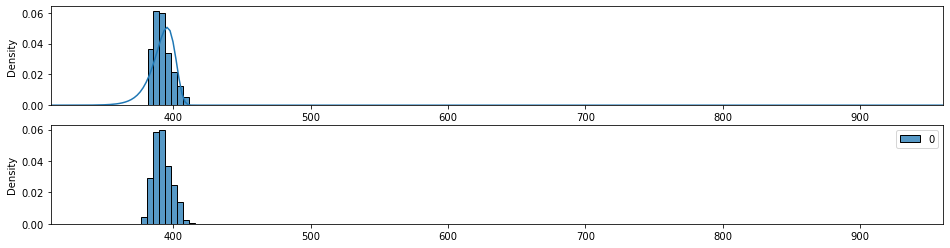

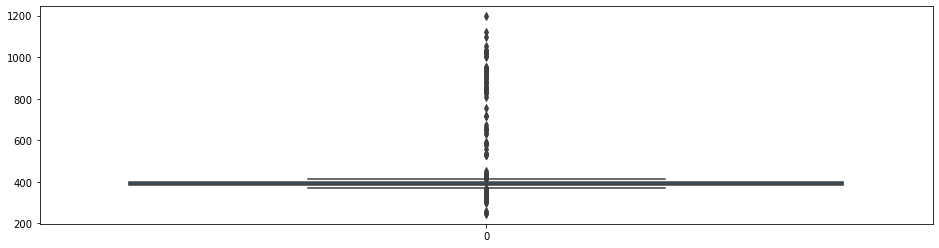

P-value(Gaussian Mixture models) = 0.701937401178744
P-value(Loggamma) = 9.66372332450141e-16
#nodes = 3


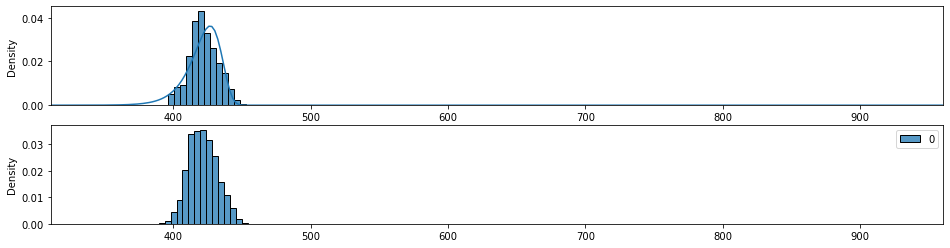

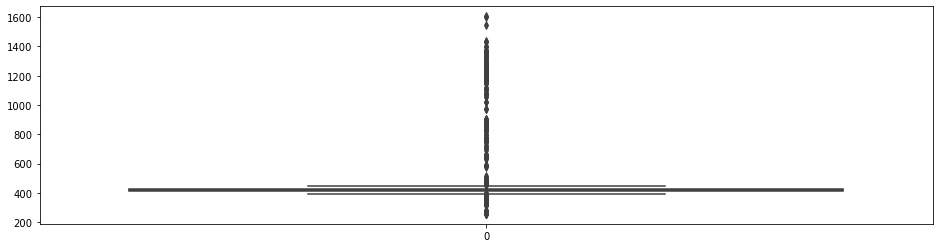

P-value(Gaussian Mixture models) = 0.018625111552863664
P-value(Loggamma) = 1.396631321341172e-15
#nodes = 4


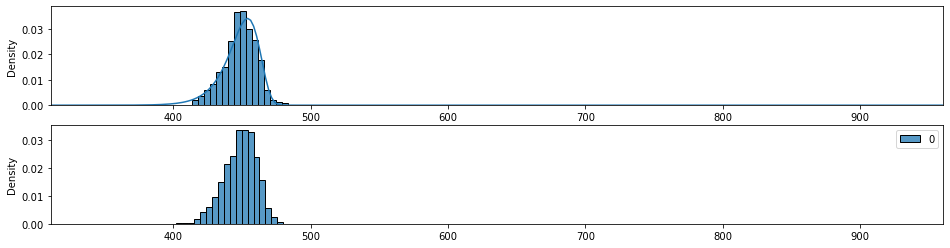

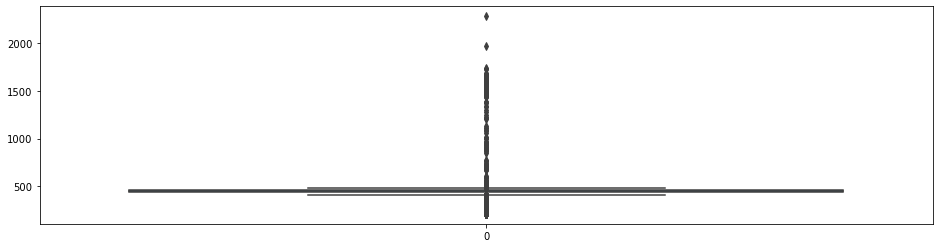

P-value(Gaussian Mixture models) = 0.11325340805760573
P-value(Loggamma) = 6.909724088100442e-06
#nodes = 5


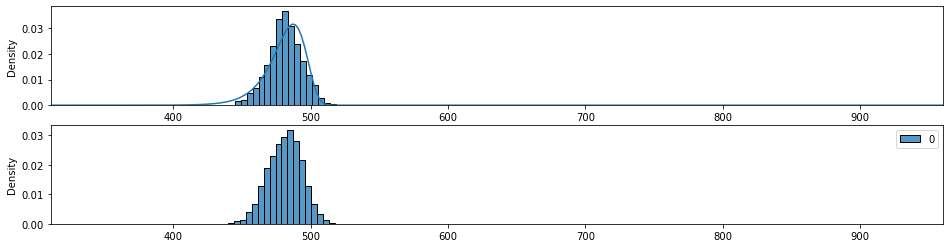

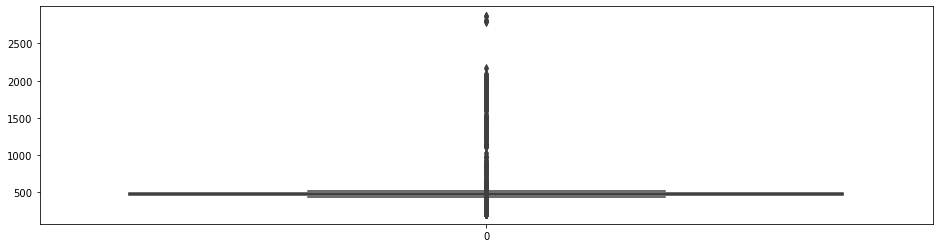

P-value(Gaussian Mixture models) = 0.013192319640109739
P-value(Loggamma) = 2.2230999158777155e-13
#nodes = 6


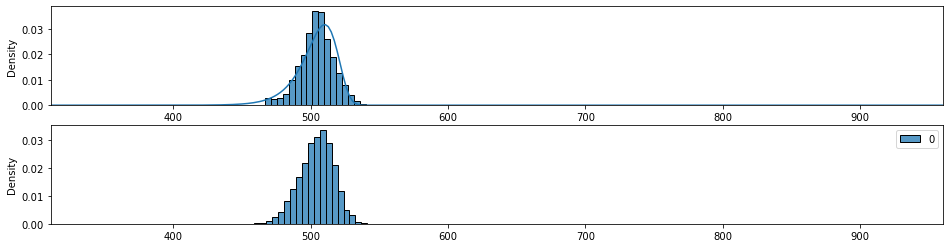

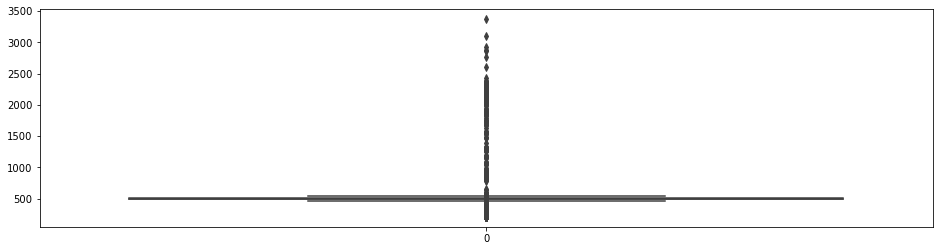

P-value(Gaussian Mixture models) = 0.16834914375262336
P-value(Loggamma) = 4.2259966144077677e-14
#nodes = 7


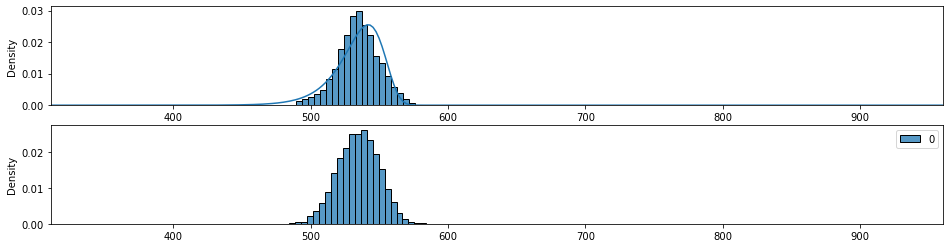

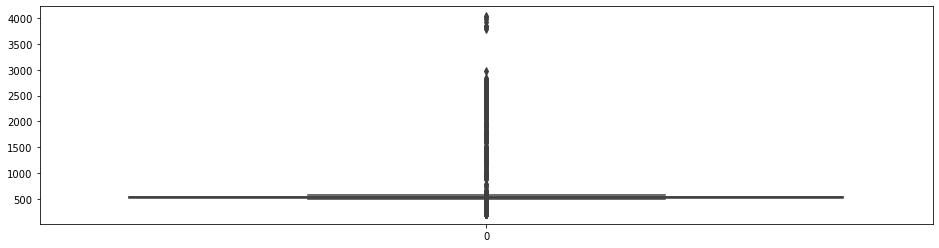

P-value(Gaussian Mixture models) = 0.20917899235812445
P-value(Loggamma) = 5.390087571558596e-21
#nodes = 8


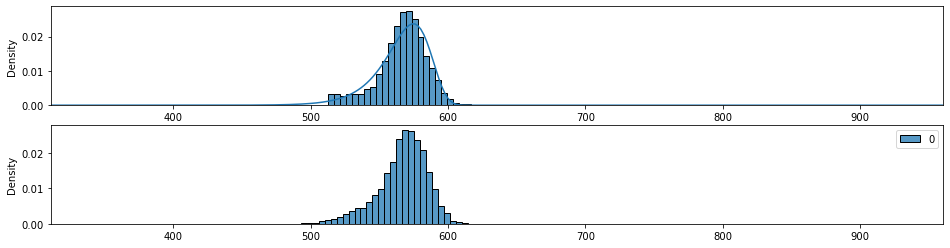

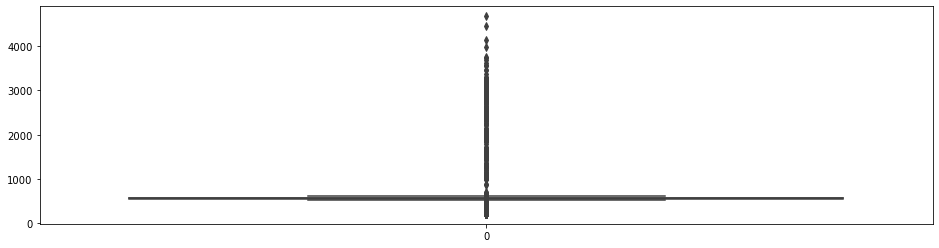

P-value(Gaussian Mixture models) = 0.0457218459874424
P-value(Loggamma) = 2.512467269402208e-09
#nodes = 9


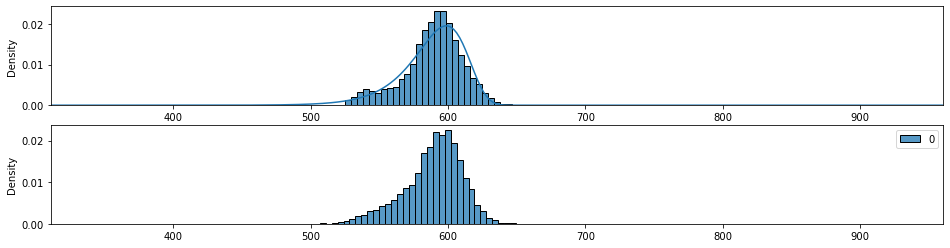

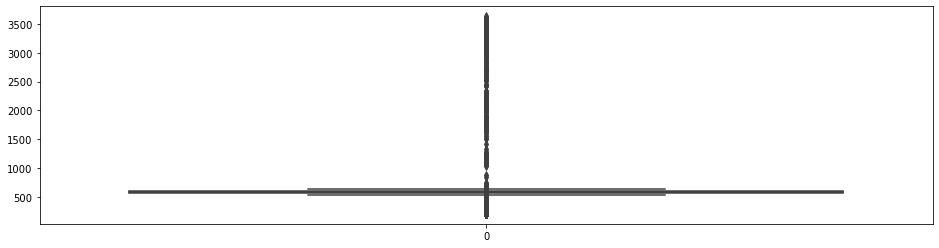

P-value(Gaussian Mixture models) = 0.005243855978942887
P-value(Loggamma) = 4.6813471228420696e-11
#nodes = 10


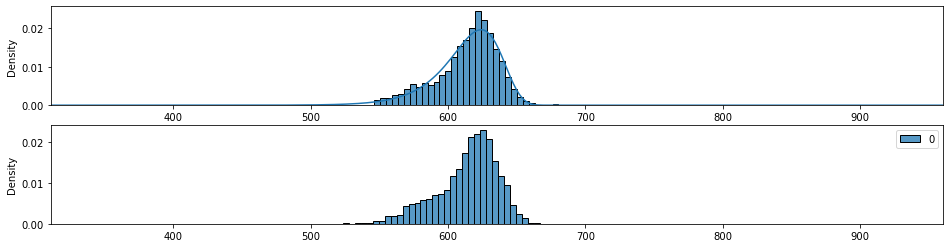

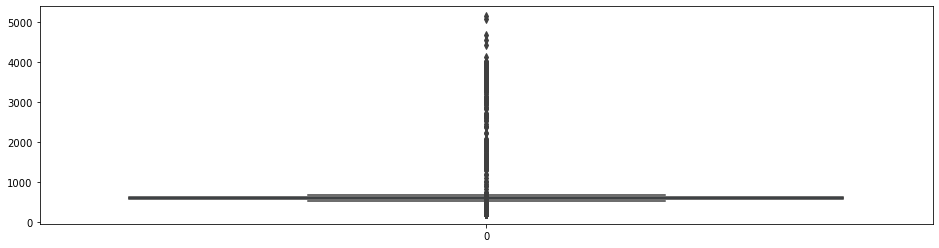

P-value(Gaussian Mixture models) = 0.8691784416486488
P-value(Loggamma) = 0.0017019397817713043
#nodes = 11


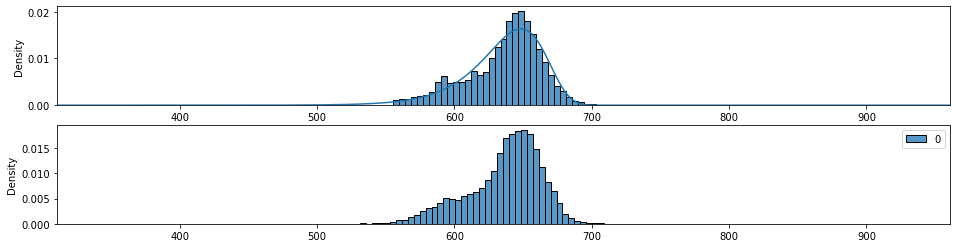

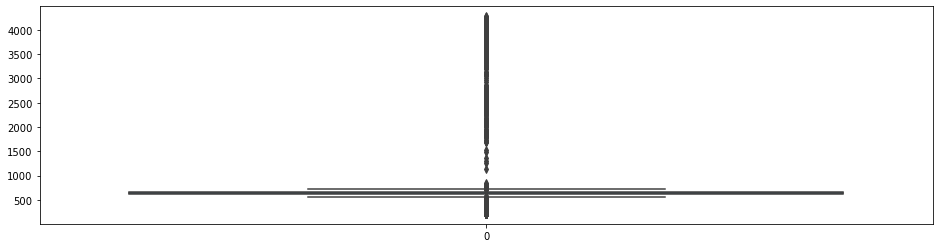

P-value(Gaussian Mixture models) = 0.3808880945515474
P-value(Loggamma) = 3.501048207379529e-06
#nodes = 12


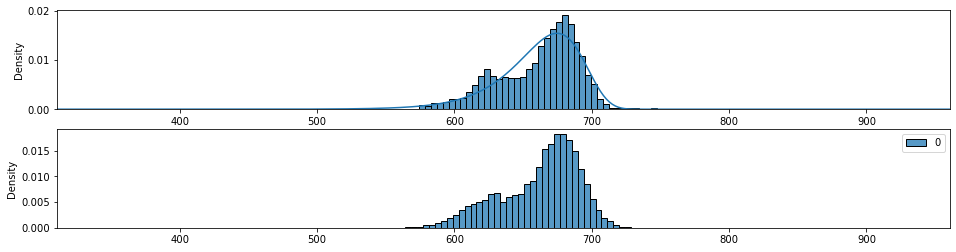

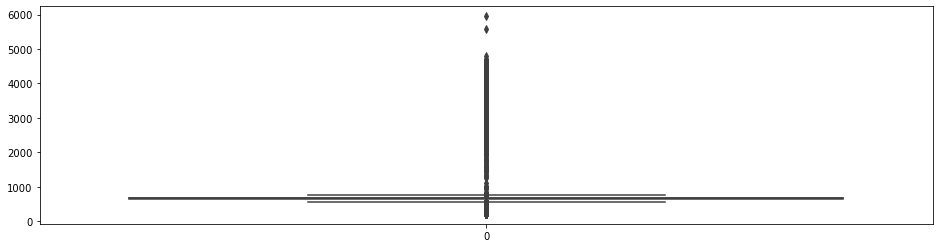

P-value(Gaussian Mixture models) = 0.11743697302459395
P-value(Loggamma) = 6.182944540626593e-10
#nodes = 13


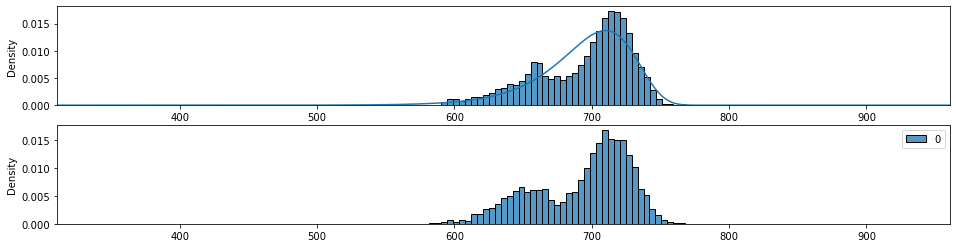

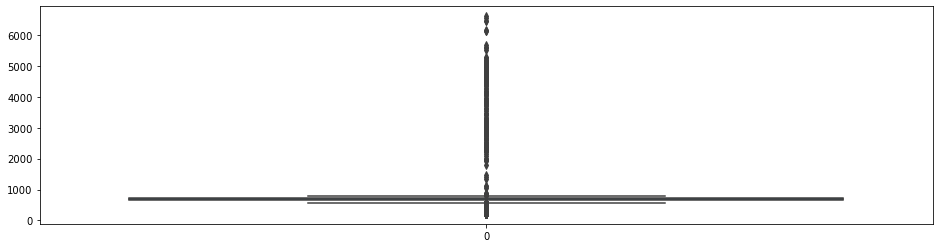

P-value(Gaussian Mixture models) = 0.008521636566294217
P-value(Loggamma) = 2.3292842477267954e-14
#nodes = 14


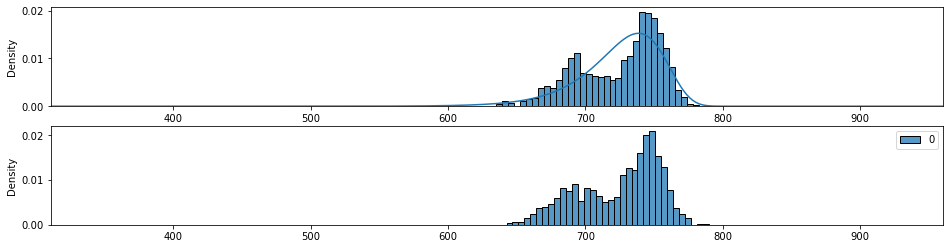

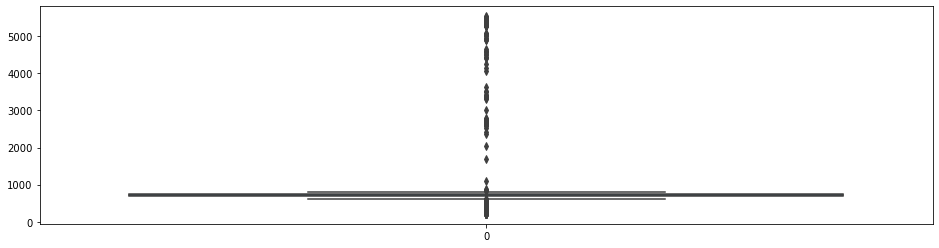

P-value(Gaussian Mixture models) = 0.9090569646522217
P-value(Loggamma) = 1.7601056585560338e-09
#nodes = 15


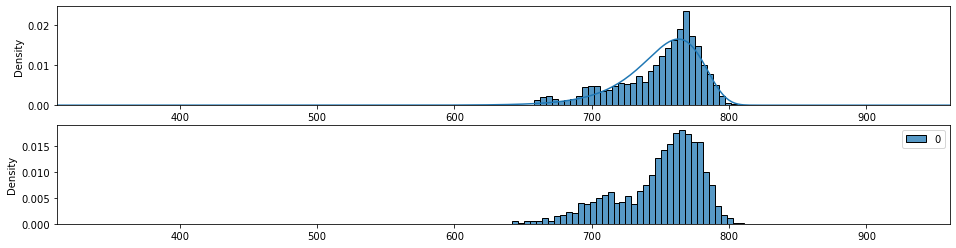

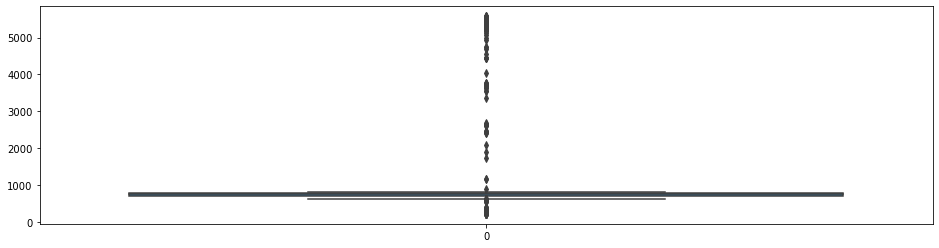

P-value(Gaussian Mixture models) = 0.5220753951508887
P-value(Loggamma) = 3.5720134748090565e-05
#nodes = 16


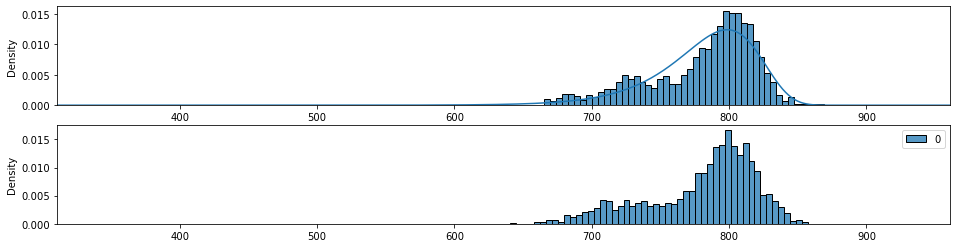

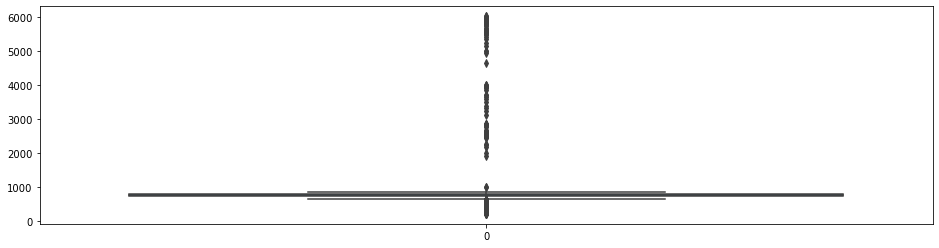

P-value(Gaussian Mixture models) = 0.9300994199991334
P-value(Loggamma) = 2.8590266822514694e-05
Loggamma loc and scale model parameters:
[ 28.24829706 342.19484777]
[1.47277377 4.60996386]
Gaussian mixture model parameters:
Mean1: [ 24.02924345 347.34966827]
Mean2: [ 28.4285818  341.95878128]
Variance1: [ 45.81623725 -92.57472235]
Variance2: [17.4384064   8.09730587]


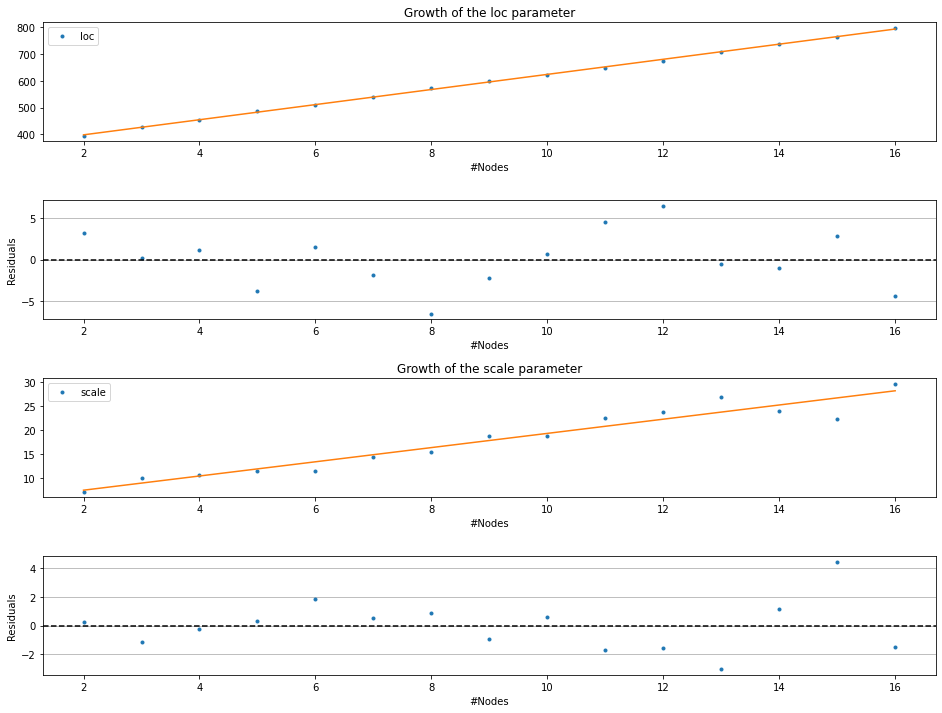

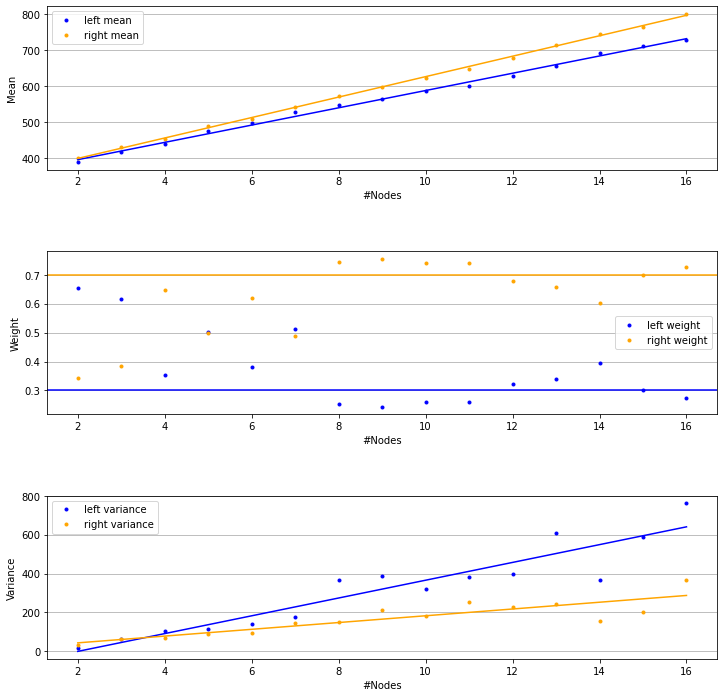

In [5]:
#/merged/jp_consensus_process_new_round.csv
#/merged/jp_consensus_process_proposal_own.csv
#/merged/jp_consensus_process_proposal_other.csv
#/merged/jp_consensus_ensure_round_and_sync_up.csv
frame_number = 2

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = np.mean(data) - 1*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 2*np.std(data)
x_axis_range = xlim_end - xlim_start

gamma_zipped_parameters = []
a_list = []; loc_list = [] ;scale_list = []
means_1 = []; weights_1 = []; variances_1 = []
means_2 = []; weights_2 = []; variances_2 = []
for index in range(len(experiment_type)):
    print('#nodes = ' + str(index+2))
    fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    #fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    
    fig2, (ax2) = plt.subplots(1,1,figsize=(16,4))
    sns.boxplot(data=data.to_numpy(), ax=ax2)
    
    # Let the network warm up and start to measure after warm up
    data = data[round(0.3*len(data)):]

    # Clean the data substantially
    # The data cannot have any outlier behaviour or else the fitting is bad
    data_start = len(data)
    data = data[data.between(data.quantile(0.05), data.quantile(1))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    
    # Plot the data in buckets
    sns.histplot(data, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
    
    # Loggamma modeling BEGIN
    a, loc, scale = stats.loggamma.fit(data, f0=1) #15
    #print("a=" + str(a) + ", loc=" + str(loc) + ", scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    gamma_fit = stats.loggamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)[1]

    # Plotting the Loggamma distribution
    X = np.linspace(xlim_start, xlim_end, 300)
    ax0.plot(X, gamma_fit.pdf(X), label="Estimated Loggamma function")
    # Loggamma modeling END
    
    # Gaussian Mixture modeling BEGIN
    data_gaussian = data.values.reshape(-1,1)
    model = mixture.GaussianMixture(n_components=2)
    model.fit(data_gaussian)
    data_samples = model.sample(len(data_gaussian))

    sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax0.set_xlim(xlim_start, xlim_end)
    ax1.set_xlim(xlim_start, xlim_end)
    plt.show()
    # Gaussian Mixture modeling END

    p_value = stats.ks_2samp(np.array(data_gaussian).flatten(), data_samples[0].flatten())
    print('P-value(Gaussian Mixture models) = ' + str(p_value[1]))
    print('P-value(Loggamma) = ' + str(p_gamma_fit))
    #print("Percentage of data cleaned: " + str((data_start-data_end)/data_start*100) + ", #samples: " + str(data_end))
    #print('Means = ' + str(model.means_))
    #print('weights = ' + str(model.weights_))
    #print('variances = ' + str(model.covariances_))
    
    # For plotting the means, weights and variances of the gaussian mixture models
    if model.means_[0][0] < model.means_[1][0]:
        means_1.append(model.means_[0][0])
        weights_1.append(model.weights_[0])
        variances_1.append(model.covariances_[0][0][0])
        means_2.append(model.means_[1][0])
        weights_2.append(model.weights_[1])
        variances_2.append(model.covariances_[1][0][0])
    else:
        means_1.append(model.means_[1][0])
        weights_1.append(model.weights_[1])
        variances_1.append(model.covariances_[1][0][0])
        means_2.append(model.means_[0][0])
        weights_2.append(model.weights_[0])
        variances_2.append(model.covariances_[0][0][0])

# Plot the loc and scale parameters and perform linear fit
print("Loggamma loc and scale model parameters:")
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
print(coefficients_loc)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
print(coefficients_scale)
poly_scale = np.poly1d(coefficients_scale)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(16,12), gridspec_kw={'hspace':0.5})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.set_title("Growth of the loc parameter")
ax0.set_xlabel('#Nodes')
ax0.legend()

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Residuals')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.set_title("Growth of the scale parameter")
ax2.set_xlabel('#Nodes')
ax2.legend();

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes')
ax3.set_ylabel('Residuals')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--')

# Plot the gaussian mixture models
# Means
fig, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(12,12), gridspec_kw={'hspace':0.5})
ax0.plot(range(2, len(means_1)+2), means_1, '.', color="blue", label="left mean")
ax0.plot(range(2, len(means_2)+2), means_2, '.', color="orange", label="right mean")
ax0.set_xlabel('#Nodes')
ax0.set_ylabel('Mean')
ax0.grid(axis='y')
ax0.legend()
# Weights
ax1.plot(range(2, len(weights_1)+2), weights_1, '.', color="blue", label="left weight")
ax1.plot(range(2, len(weights_2)+2), weights_2, '.', color="orange", label="right weight")
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Weight')
ax1.grid(axis='y')
ax1.legend()
# Variances
ax2.plot(range(2, len(variances_1)+2), variances_1, '.', color="blue", label="left variance")
ax2.plot(range(2, len(variances_2)+2), variances_2, '.', color="orange", label="right variance")
ax2.set_xlabel('#Nodes')
ax2.set_ylabel('Variance')
ax2.grid(axis='y')
ax2.legend()

# Fit Means, Weights and variances into a 1d model
# Means
coefficients_mean_1 = np.polyfit(range(2, len(means_1)+2), means_1, 1)
coefficients_mean_2 = np.polyfit(range(2, len(means_2)+2), means_2, 1)
poly_mean_1 = np.poly1d(coefficients_mean_1)
poly_mean_2 = np.poly1d(coefficients_mean_2)
ax0.plot(range(2, len(means_1)+2), poly_mean_1(range(2, len(means_1)+2)), color="blue", label="left weight model")
ax0.plot(range(2, len(means_2)+2), poly_mean_2(range(2, len(means_1)+2)), color="orange", label="right weight model")
print("Gaussian mixture model parameters:")
print("Mean1: " + str(coefficients_mean_1))
print("Mean2: " + str(coefficients_mean_2))

# Weights
ax1.axhline(y=.3, color="blue")
ax1.axhline(y=.7, color="orange")

#Variances
coefficients_variance_1 = np.polyfit(range(2, len(variances_1)+2), variances_1, 1)
coefficients_variance_2 = np.polyfit(range(2, len(variances_2)+2), variances_2, 1)
poly_variance_1 = np.poly1d(coefficients_variance_1)
poly_variance_2 = np.poly1d(coefficients_variance_2)
ax2.plot(range(2, len(variances_1)+2), poly_variance_1(range(2, len(variances_1)+2)), color="blue", label="left variance model")
ax2.plot(range(2, len(variances_2)+2), poly_variance_2(range(2, len(variances_2)+2)), color="orange", label="right variance model")
print("Variance1: " + str(coefficients_variance_1))
print("Variance2: " + str(coefficients_variance_2))

#nodes = 2
a=1, loc=213.63864969905308, scale=1.7432159530193823
(array(212.63243814), array(4.9986287))


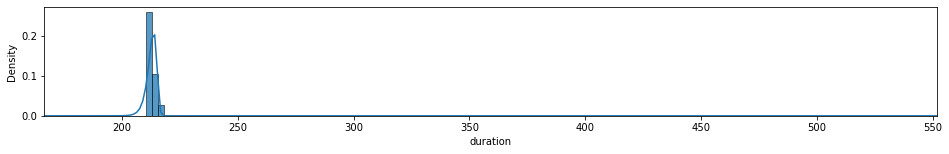

P-value(gamma) = KstestResult(statistic=0.15694983221119416, pvalue=1.6937410437675967e-22)
Percentage of data cleaned: 12.178387650085764, #samples: 1024
#nodes = 3
a=1, loc=213.67276432215309, scale=1.7618190472706485
(array(212.65581477), array(5.1058858))


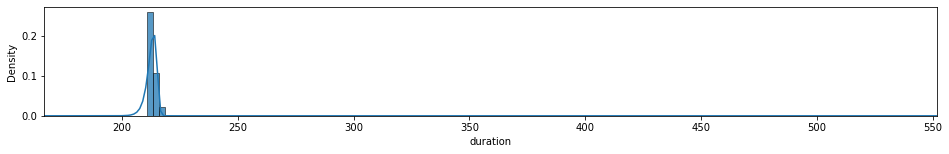

P-value(gamma) = KstestResult(statistic=0.17057243701155902, pvalue=6.597302794979292e-26)
Percentage of data cleaned: 13.043478260869565, #samples: 1000
#nodes = 4
a=1, loc=230.0220581150965, scale=3.497023879736421
(array(228.00352115), array(20.11618824))


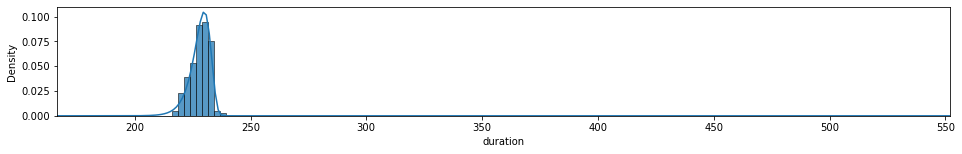

P-value(gamma) = KstestResult(statistic=0.03628453639415258, pvalue=0.20310490822456584)
Percentage of data cleaned: 12.077789150460594, #samples: 859
#nodes = 5
a=1, loc=246.95953866923224, scale=4.258624167641994
(array(244.50139409), array(29.83232652))


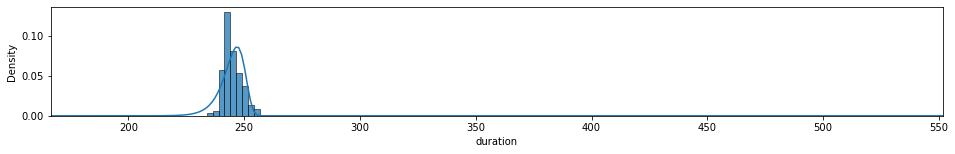

P-value(gamma) = KstestResult(statistic=0.1492623039128402, pvalue=1.4406030017232927e-16)
Percentage of data cleaned: 14.196891191709845, #samples: 828
#nodes = 6
a=1, loc=270.97964078973325, scale=7.20369211279403
(array(266.82155686), array(85.36085971))


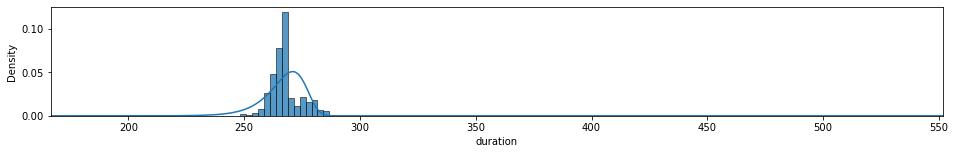

P-value(gamma) = KstestResult(statistic=0.22282265536958956, pvalue=3.234769386236244e-27)
Percentage of data cleaned: 14.265734265734265, #samples: 613
#nodes = 7
a=1, loc=292.0949124711552, scale=6.471032509841518
(array(288.35973114), array(68.88039967))


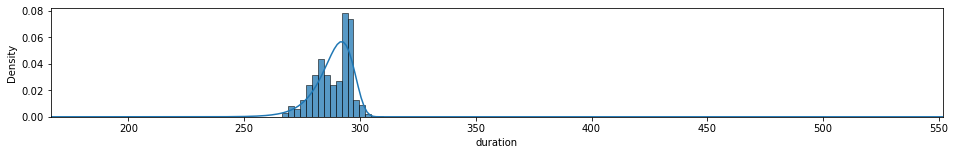

P-value(gamma) = KstestResult(statistic=0.11019391215045726, pvalue=5.589664817544298e-09)
Percentage of data cleaned: 10.939226519337018, #samples: 806
#nodes = 8
a=1, loc=319.3849961898085, scale=10.68346868214391
(array(313.21833071), array(187.74702219))


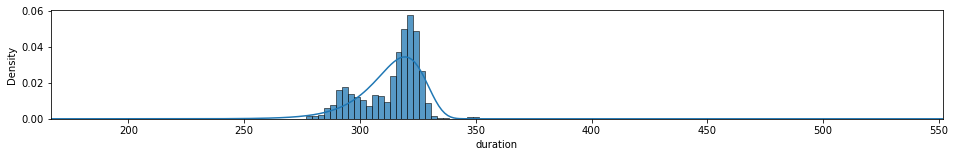

P-value(gamma) = KstestResult(statistic=0.09805179692091165, pvalue=7.59891239006617e-07)
Percentage of data cleaned: 9.692671394799055, #samples: 764
#nodes = 9
a=1, loc=331.96989699184513, scale=18.749264126479595
(array(321.14752803), array(578.25174139))


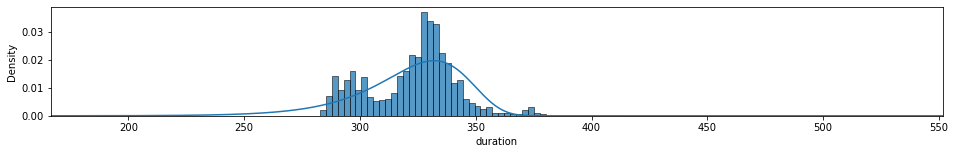

P-value(gamma) = KstestResult(statistic=0.09295530471232993, pvalue=3.6371605502985176e-06)
Percentage of data cleaned: 9.95260663507109, #samples: 760
#nodes = 10
a=1, loc=349.21383561507685, scale=24.273803751852174
(array(335.20261584), array(969.22401845))


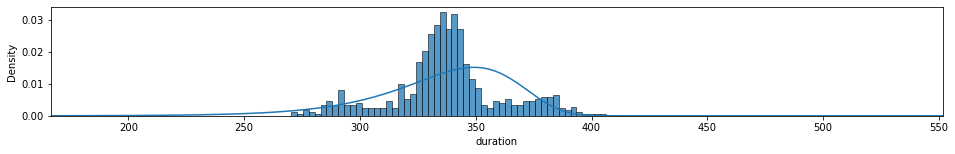

P-value(gamma) = KstestResult(statistic=0.17048034757076247, pvalue=1.4324139991254705e-17)
Percentage of data cleaned: 9.664429530201343, #samples: 673
#nodes = 11
a=1, loc=361.1128521871884, scale=26.079364249627567
(array(346.05943461), array(1118.77433592))


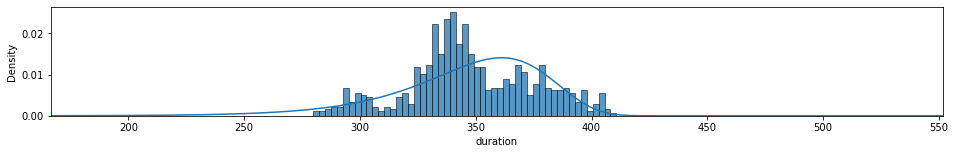

P-value(gamma) = KstestResult(statistic=0.12198528981910006, pvalue=1.7485963428408145e-09)
Percentage of data cleaned: 10.193548387096774, #samples: 696
#nodes = 12
a=1, loc=383.66383260523185, scale=35.729191899031456
(array(363.04038335), array(2099.88195931))


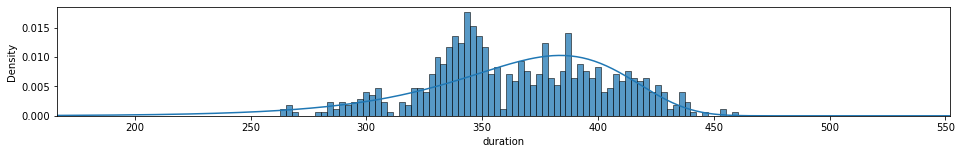

P-value(gamma) = KstestResult(statistic=0.10581227153363004, pvalue=6.732842969758118e-07)
Percentage of data cleaned: 9.945504087193461, #samples: 661
#nodes = 13
a=1, loc=400.97760878739473, scale=39.22600739091088
(array(378.33574285), array(2531.02658384))


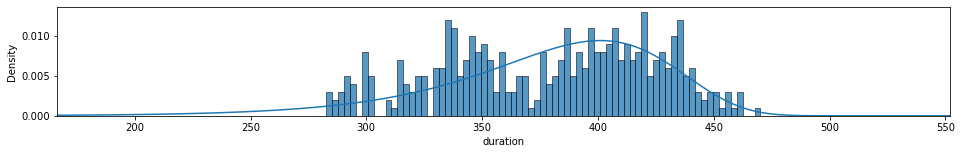

P-value(gamma) = KstestResult(statistic=0.08979942186632683, pvalue=0.003356830457971794)
Percentage of data cleaned: 9.885057471264368, #samples: 392
#nodes = 14
a=1, loc=416.70399562371693, scale=45.59617716191302
(array(390.38516791), array(3419.83663081))


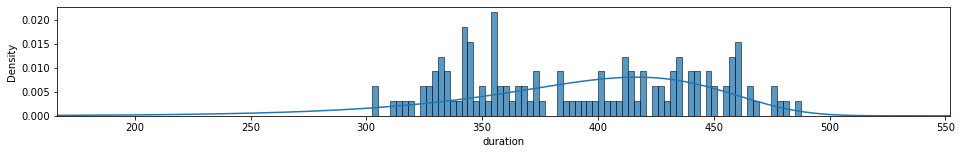

P-value(gamma) = KstestResult(statistic=0.1292358077576682, pvalue=0.0270374426578666)
Percentage of data cleaned: 9.352517985611511, #samples: 126
#nodes = 15
a=1, loc=426.5197308612197, scale=33.83842301082751
(array(406.98766302), array(1883.51344819))


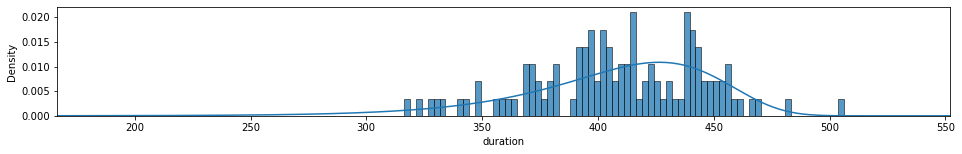

P-value(gamma) = KstestResult(statistic=0.07544705781740924, pvalue=0.5277013217764603)
Percentage of data cleaned: 9.75609756097561, #samples: 111
#nodes = 16
a=1, loc=446.4659831991121, scale=43.92285698093872
(array(421.1130221), array(3173.43536665))


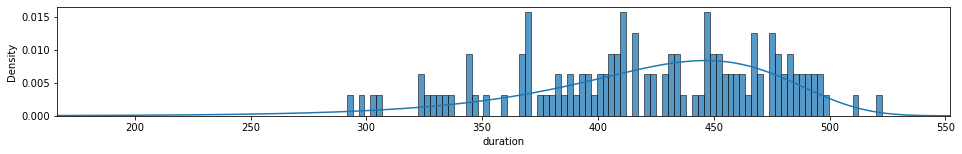

P-value(gamma) = KstestResult(statistic=0.06772280478685355, pvalue=0.5960601608577594)
Percentage of data cleaned: 8.823529411764707, #samples: 124
[ 17.72240141 167.39040701]
[  3.48737824 -11.18413986]


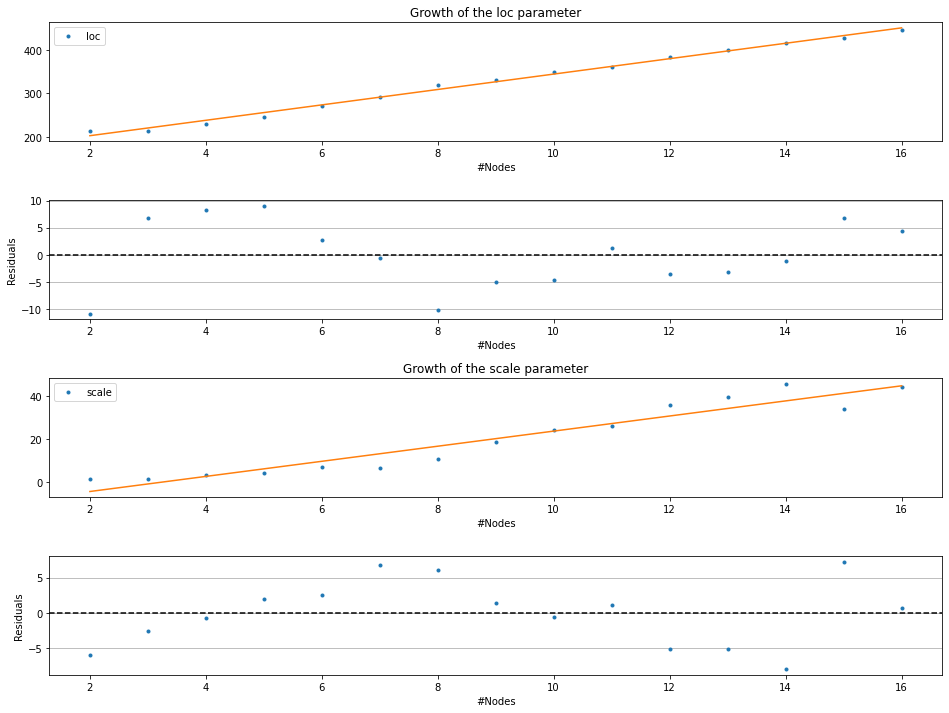

In [8]:
#/merged/jp_consensus_process_new_round.csv
#/merged/jp_consensus_process_proposal_own.csv
#/merged/jp_consensus_process_proposal_other.csv
#/merged/jp_consensus_ensure_round_and_sync_up.csv
frame_number = 1

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = np.mean(data) - 1*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 2*np.std(data)
x_axis_range = xlim_end - xlim_start

gamma_zipped_parameters = []
a_list = []
loc_list = []
scale_list = []
for index in range(len(experiment_type)):
    print('#nodes = ' + str(index+2))
    #fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    #remove first 20% of the data
    #data = data[round(0.4*len(data)):round(0.9*len(data))]
    data = data[round(0.3*len(data)):]

    #Clean the data a bit
    data_start = len(data)
    #data = data[data.between(data.quantile(0.02), data.quantile(.98))]
    data = data[data.between(data.quantile(0.05), data.quantile(1))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    
    #data = data.values.reshape(-1,1)
    #model = mixture.GaussianMixture(n_components=2)
    #model.fit(data)
    #data_samples = model.sample(len(data))
    
    #GAMMA TEST
    a, loc, scale = stats.loggamma.fit(data, f0=1) #15
    print("a=" + str(a) + ", loc=" + str(loc) + ", scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    #gamma_zipped = zip([a], [loc], [scale])
    #gamma_zipped_parameters.append(gamma_zipped)
    
    gamma_fit = stats.loggamma(a, loc, scale)
    print(gamma_fit.stats())
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #a, beta, loc, scale = stats.beta.fit(data, f0=30)
    #gamma_zipped = zip([a], [beta], [loc], [scale])
    #gamma_zipped_parameters.append(gamma_zipped)
    #beta_fit = stats.beta(alpha, beta, loc, scale)
    #p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(xlim_start, xlim_end, 300)
    ax0.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
    #ax0.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    #END GAMMA TEST

    sns.histplot(data, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
    #sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    plt.show()

    #p_value = stats.ks_2samp(np.array(data).flatten(), data_samples[0].flatten())
    #print('P-value = ' + str(p_value[1]))
    print('P-value(gamma) = ' + str(p_gamma_fit))
    print("Percentage of data cleaned: " + str((data_start-data_end)/data_start*100) + ", #samples: " + str(data_end))
    #print('Means = ' + str(model.means_))
    #print('weights = ' + str(model.weights_))
    #print('variances = ' + str(model.covariances_))
    
# Plot the loc and scale parameters and perform linear fit
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
print(coefficients_loc)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
print(coefficients_scale)
poly_scale = np.poly1d(coefficients_scale)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(16,12), gridspec_kw={'hspace':0.5})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.set_title("Growth of the loc parameter")
ax0.set_xlabel('#Nodes')
ax0.legend()

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Residuals')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.set_title("Growth of the scale parameter")
ax2.set_xlabel('#Nodes')
ax2.legend();

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes')
ax3.set_ylabel('Residuals')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--')

#nodes = 2
alpha=3
loc=202.2674333381023
scale=5.427448362906704


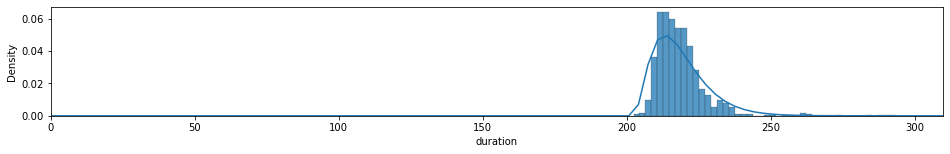

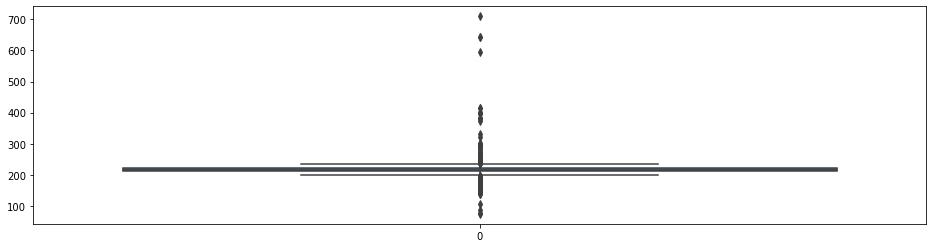

#nodes = 3
alpha=3
loc=205.87428031250775
scale=5.0828402968890005


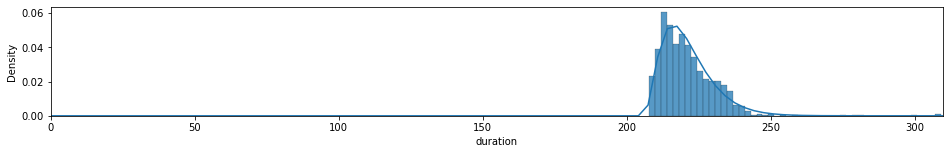

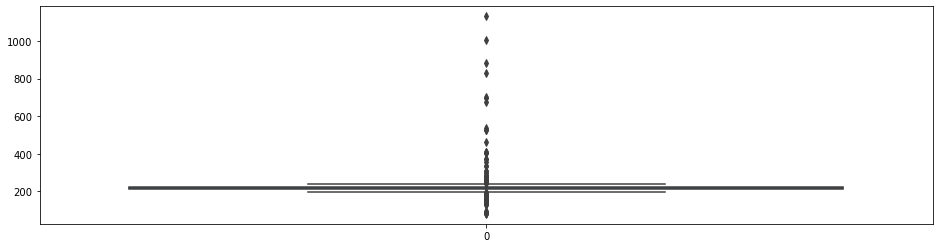

#nodes = 4
alpha=3
loc=167.2953778929335
scale=18.600215291136074


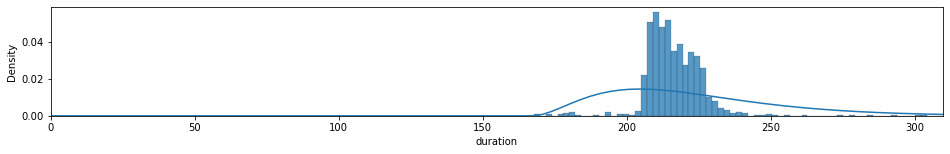

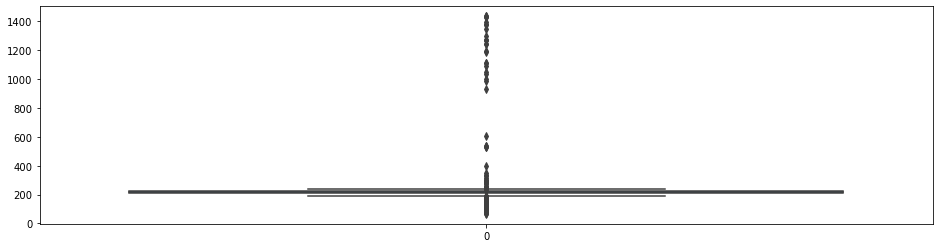

#nodes = 5
alpha=3
loc=175.6833849027576
scale=15.674171170022737


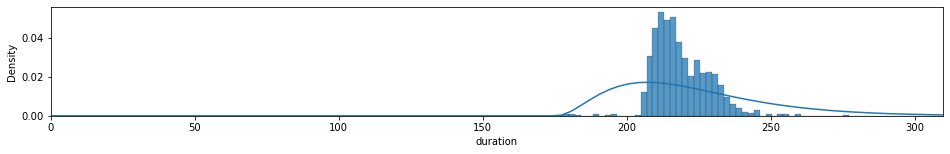

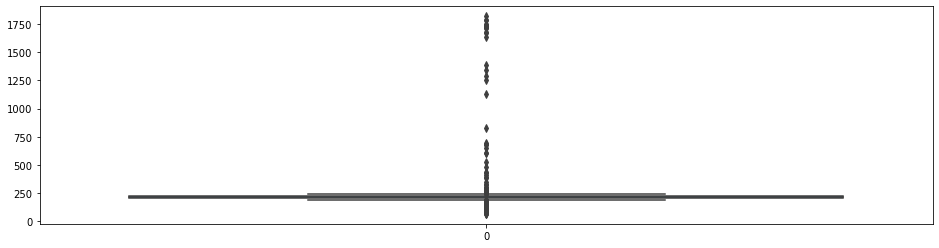

#nodes = 6
alpha=3
loc=106.83103581079916
scale=39.386349918307324


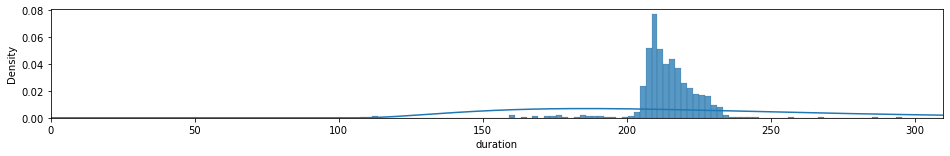

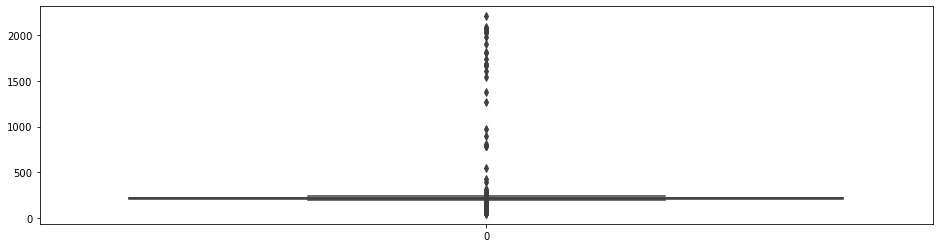

#nodes = 7
alpha=3
loc=139.91565358258487
scale=31.369747038866027


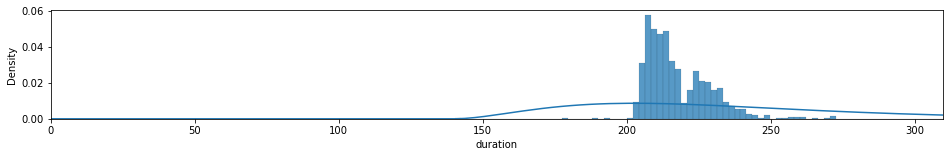

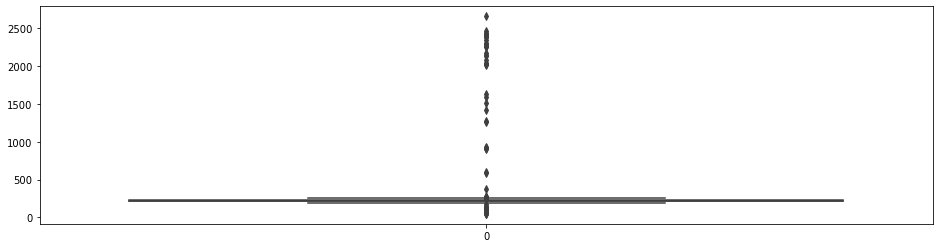

#nodes = 8
alpha=3
loc=150.64987156494897
scale=27.153657159729587


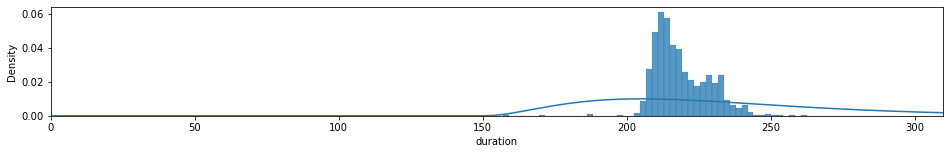

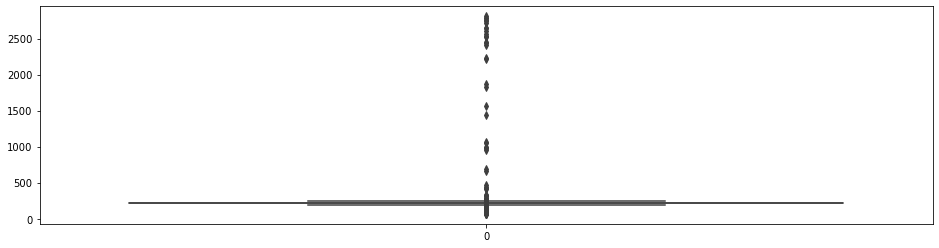

#nodes = 9
alpha=3
loc=196.70196956442473
scale=9.543256483541224


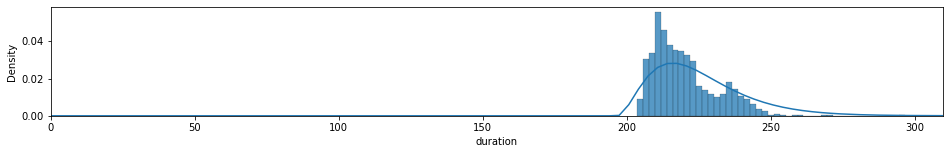

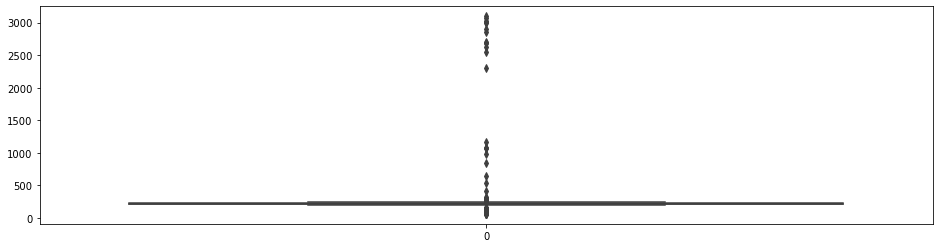

#nodes = 10
alpha=3
loc=101.72676928425098
scale=45.78554229132967


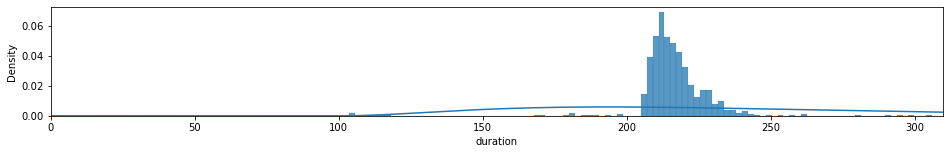

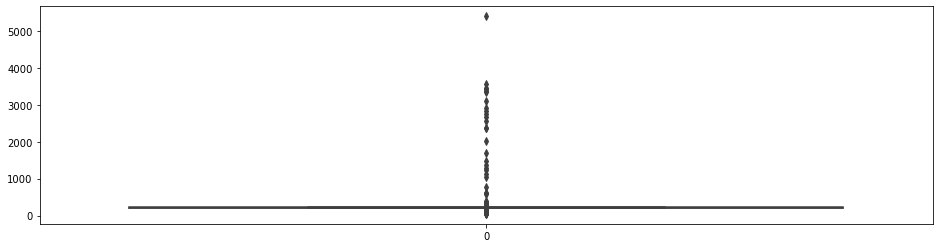

#nodes = 11
alpha=3
loc=125.21271466069493
scale=34.94650137716717


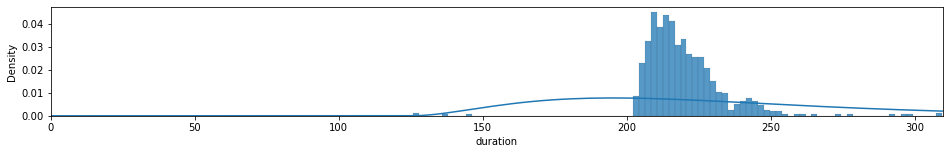

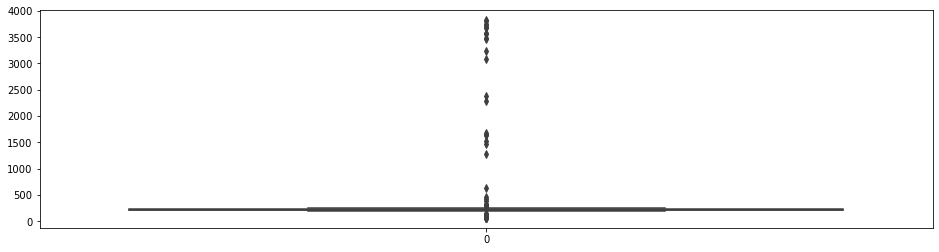

#nodes = 12
alpha=3
loc=121.82478234734516
scale=37.71655248308817


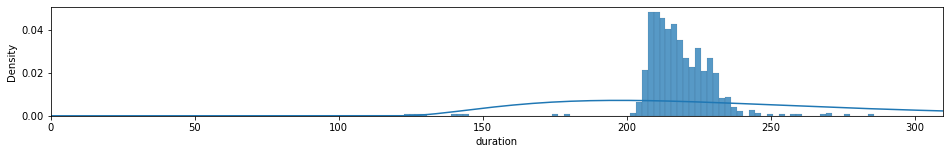

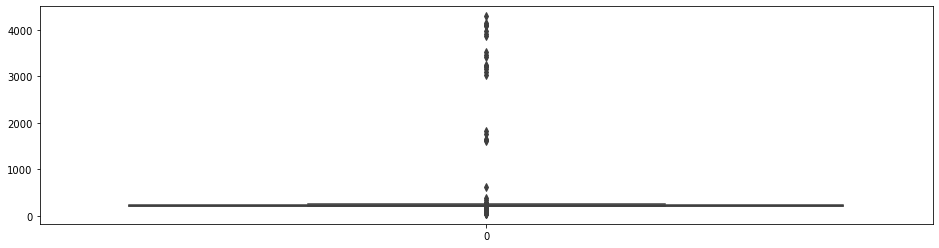

#nodes = 13
alpha=3
loc=152.76488074940048
scale=25.470904928231946


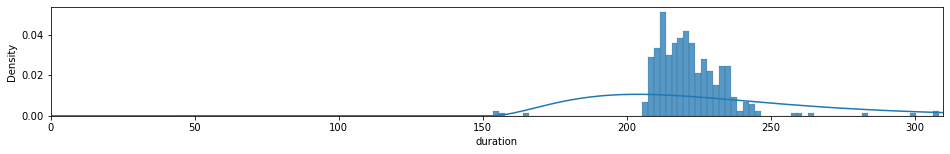

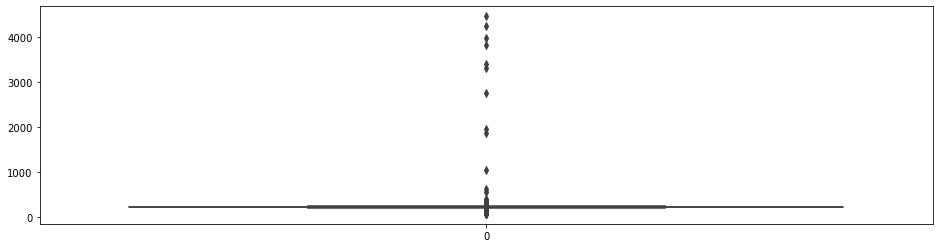

#nodes = 14
alpha=3
loc=204.24304530790837
scale=6.141029044464058


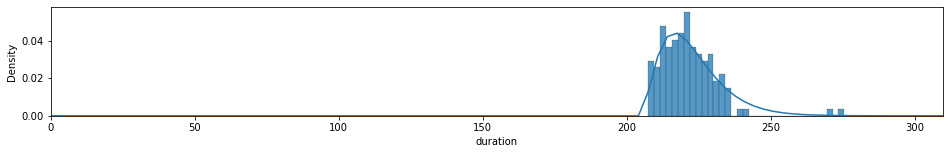

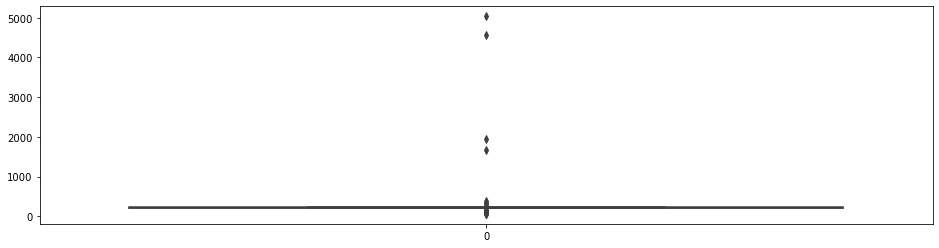

#nodes = 15
alpha=3
loc=204.40668280435767
scale=6.232389404400337


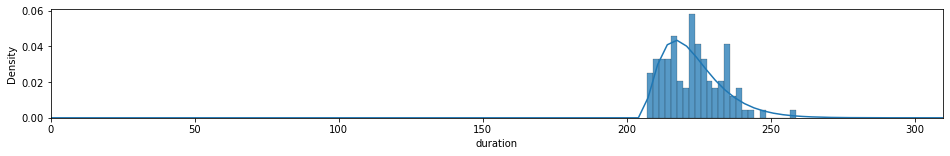

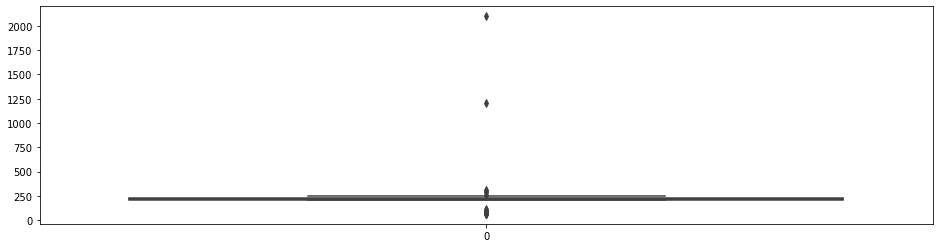

#nodes = 16
alpha=3
loc=144.03114032234993
scale=41.377528053510716


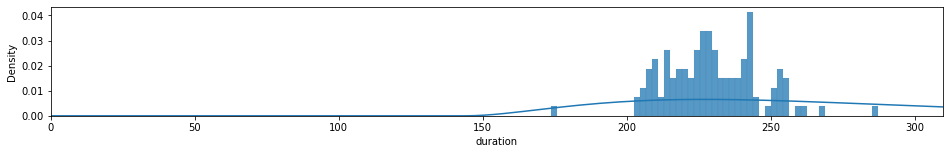

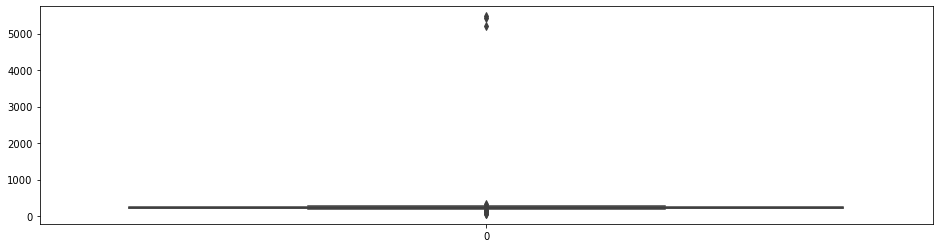

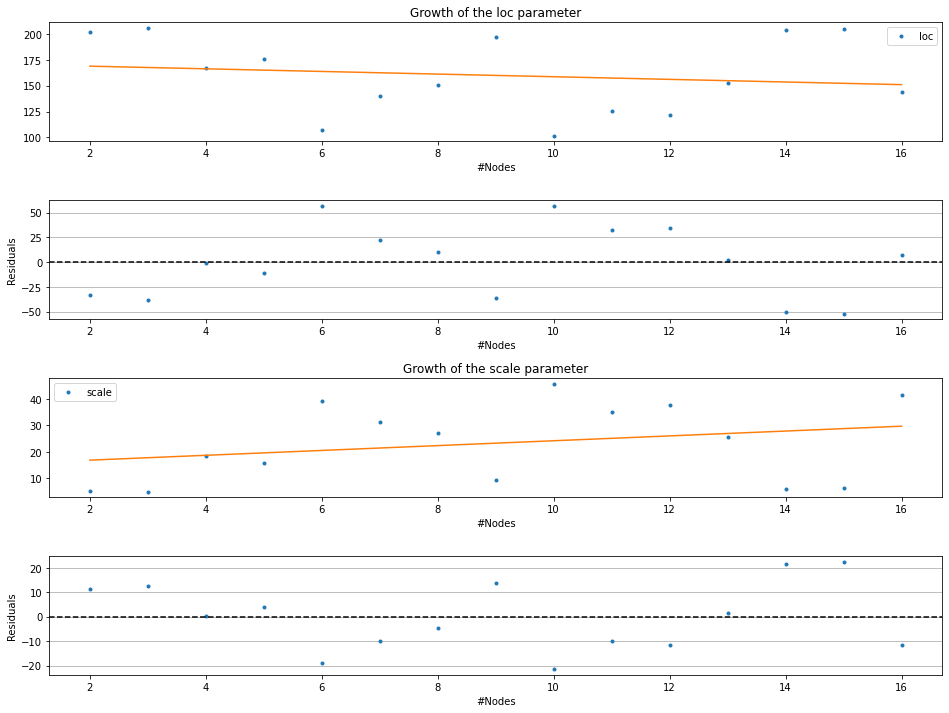

In [23]:
#/merged/jp_consensus_process_new_round.csv
#/merged/jp_consensus_process_proposal_own.csv
#/merged/jp_consensus_process_proposal_other.csv
#/merged/jp_consensus_ensure_round_and_sync_up.csv
frame_number = 0

# Calculate the x-axis limits
data = data_frames[frame_number]['duration']
#data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_start = 0#np.mean(data) - 3*np.std(data)
data = data_frames[(len(experiment_type)-1) * 4 + frame_number]['duration']
data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 3*data.std())]
xlim_end = np.mean(data) + 3*np.std(data)
x_axis_range = xlim_end - xlim_start

gamma_zipped_parameters = []
a_list = []
loc_list = []
scale_list = []
for index in range(len(experiment_type)):
    print('#nodes = ' + str(index+2))
    #fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,4))
    fig, ax0 = plt.subplots(1,1,figsize=(16,2))

    data = data_frames[index*4 + frame_number]['duration']
    
    fig2, (ax2) = plt.subplots(1,1,figsize=(16,4))
    sns.boxplot(data=data.to_numpy(), ax=ax2)
    
    data = data[round(0.3*len(data)):]

    #Clean the data a bit
    data_start = len(data)
    data = data[data.between(data.quantile(0.03), data.quantile(.99))]
    #data = data[(data <= data.mean() + 2*data.std()) & (data >= data.mean() - 2*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data_end = len(data)
    
    #data = data.values.reshape(-1,1)

    #model = mixture.GaussianMixture(n_components=6)
    #model.fit(data)
    #data_samples = model.sample(len(data))
    
    #GAMMA TEST
    a, loc, scale = stats.gamma.fit(data, f0=3)
    print("alpha=" + str(a))
    print("loc=" + str(loc))
    print("scale=" + str(scale))
    a_list.append(a); loc_list.append(loc); scale_list.append(scale)
    gamma_zipped = zip([a], [loc], [scale])
    gamma_zipped_parameters.append(gamma_zipped)
    
    gamma_fit = stats.gamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #a, beta, loc, scale = stats.beta.fit(data, f0=30)
    #gamma_zipped = zip([a], [beta], [loc], [scale])
    #gamma_zipped_parameters.append(gamma_zipped)
    #beta_fit = stats.beta(alpha, beta, loc, scale)
    #p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(0, 1000, 300)
    ax0.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
    #ax0.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    #END GAMMA TEST

    sns.histplot(data, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
    #sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax0.set_xlim(xlim_start, xlim_end)
    #ax1.set_xlim(xlim_start, xlim_end)
    plt.show()

    #p_value = stats.ks_2samp(np.array(data).flatten(), data_samples[0].flatten())
    #print('P-value = ' + str(p_value[1]))
    #print('P-value(gamma) = ' + str(p_gamma_fit))
    #print("Percentage of data cleaned: " + str((data_start-data_end)/data_start*100))
    #print('Means = ' + str(model.means_))
    #print('weights = ' + str(model.weights_))
    #print('variances = ' + str(model.covariances_))
    
# Plot the loc and scale parameters and perform linear fit
coefficients_loc = np.polyfit(range(2, len(loc_list)+2), loc_list, 1)
poly_loc = np.poly1d(coefficients_loc)

coefficients_scale = np.polyfit(range(2, len(scale_list)+2), scale_list, 1)
poly_scale = np.poly1d(coefficients_scale)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1,figsize=(16,12), gridspec_kw={'hspace':0.5})
# Plot loc + residuals
ax0.plot(range(2, len(loc_list)+2), loc_list, '.', label="loc")
ax0.plot(range(2, len(loc_list)+2), poly_loc(range(2, len(loc_list)+2)))
ax0.set_title("Growth of the loc parameter")
ax0.set_xlabel('#Nodes')
ax0.legend()

pred_loc = poly_loc(range(2, len(loc_list)+2)) - loc_list
ax1.plot(range(2, len(loc_list)+2), pred_loc, '.')
ax1.set_xlabel('#Nodes')
ax1.set_ylabel('Residuals')
ax1.grid(axis='y')
ax1.axhline(y=0, c='black', ls='--')

# Plot scale + residuals
ax2.plot(range(2, len(scale_list)+2), scale_list, '.', label="scale")
ax2.plot(range(2, len(scale_list)+2), poly_scale(range(2, len(scale_list)+2)))
ax2.set_title("Growth of the scale parameter")
ax2.set_xlabel('#Nodes')
ax2.legend();

pred_scale = poly_scale(range(2, len(scale_list)+2)) - scale_list
ax3.plot(range(2, len(scale_list)+2), pred_scale, '.')
ax3.set_xlabel('#Nodes')
ax3.set_ylabel('Residuals')
ax3.grid(axis='y')
ax3.axhline(y=0, c='black', ls='--')

In [31]:
# Generate data for the gaussian mixture distribution
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data

In [115]:
# Calculate the parameters
weights = model.means_.flatten()
means = model.means_.flatten()
variances = model.covariances_.flatten()
zipped = zip(weights, means, variances)
print(list(zipped))

[(828.9474207536912, 828.9474207536912, 687.6968937923702), (738.2225297998947, 738.2225297998947, 1223.7490306989569)]


(0.0, 1000.0)

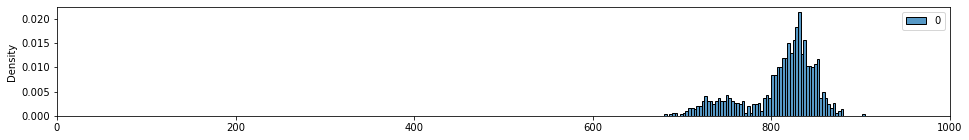

In [112]:
fig, (ax0) = plt.subplots(1,1,figsize=(16,2))

X = generate_data(1000, np.array([[742],[828]]), np.array([[[530]], [[415]]]), [.22,.78])

#model2 = mixture.GaussianMixture(n_components=2, weights_init=[.31,.69], means_init=[[389],[403]], precisions_init=[[[19]], [[17]]])
#data_samples = model2.sample(400)
sns.histplot(X, ax=ax0, stat="density", label="Real Data", binwidth=3)
ax0.set_xlim(0, 1000)

Gamma p score: KstestResult(statistic=0.3799212647523855, pvalue=1.5958773552583356e-38)
Beta p score: KstestResult(statistic=0.5016275700942059, pvalue=9.857065962144755e-69)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.39778766588729053, pvalue=2.7552032349691496e-97)
Beta p score: KstestResult(statistic=0.39965167503740584, pvalue=3.114608785998341e-98)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.41167485546279603, pvalue=5.544564689381867e-133)
Beta p score: KstestResult(statistic=0.41227309419181746, pvalue=2.1950765479098087e-133)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.41338875788830254, pvalue=1.7161279899477708e-172)
Beta p score: KstestResult(statistic=0.41341240296845716, pvalue=1.6367998827188505e-172)
Percentage of data cleaned: 0.0
Gamma p score: KstestResult(statistic=0.9786343595792448, pvalue=0.0)
Beta p score: KstestResult(statistic=0.38743435813471483, pvalue=4.1147595600794044e-17

IndexError: list index out of range

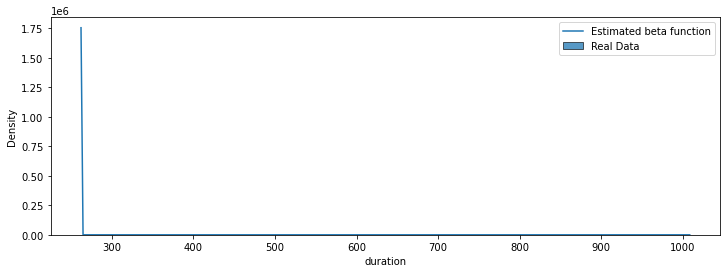

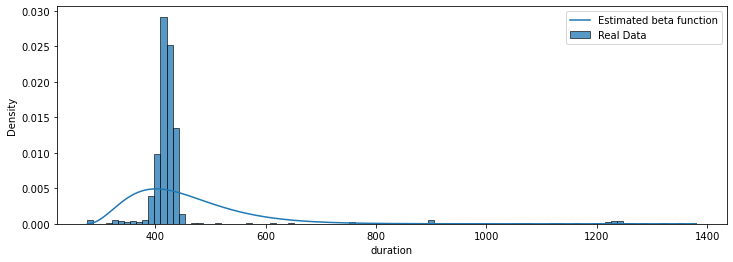

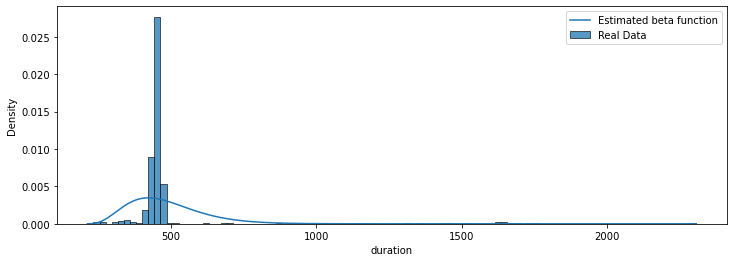

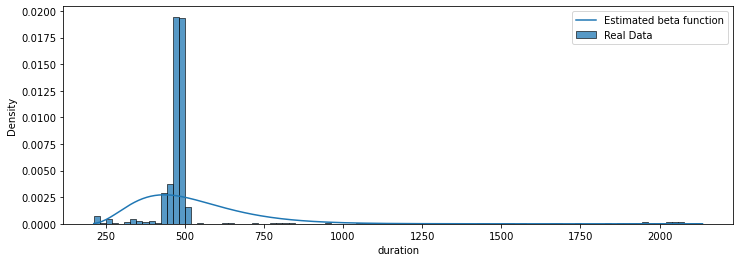

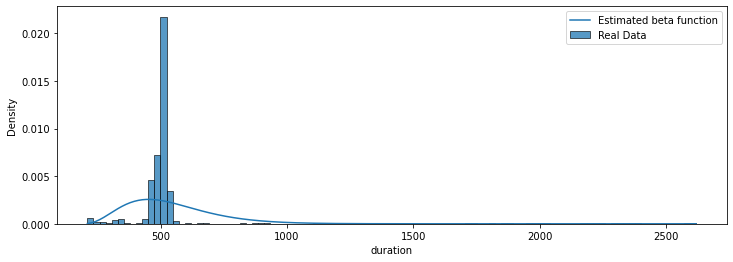

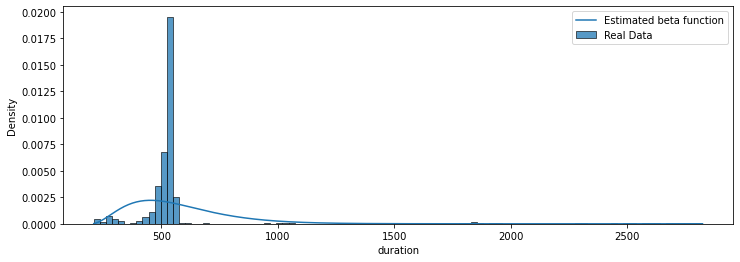

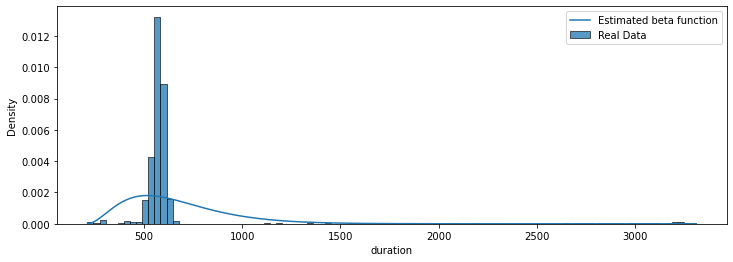

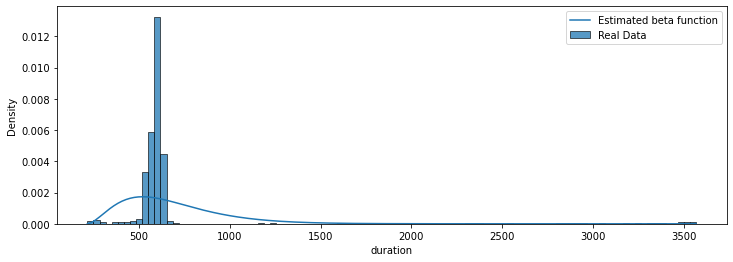

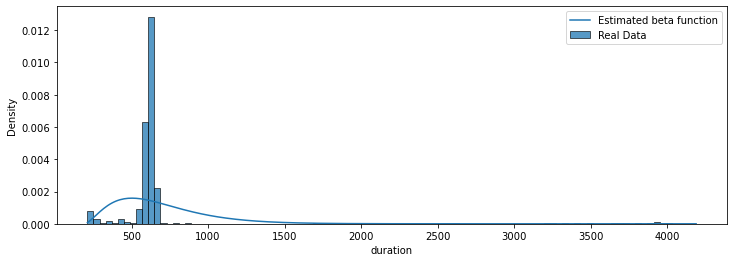

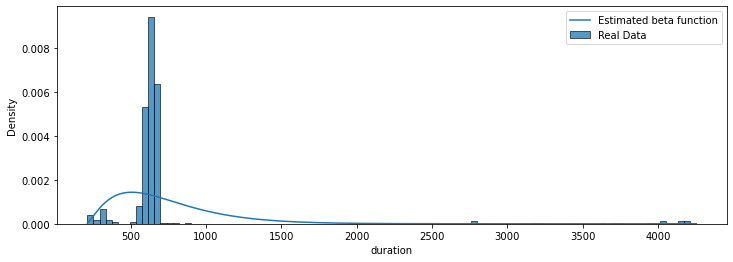

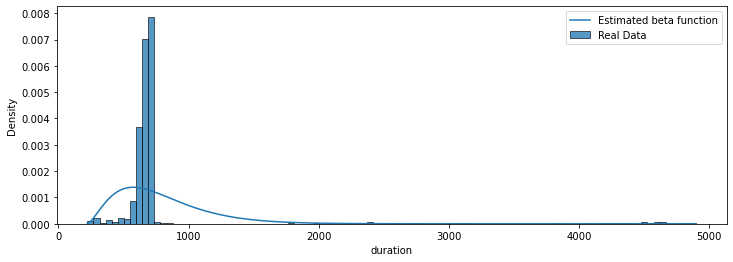

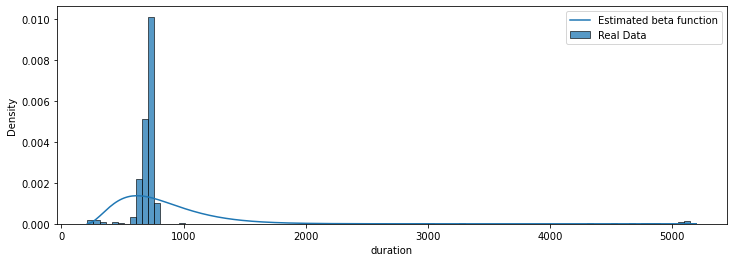

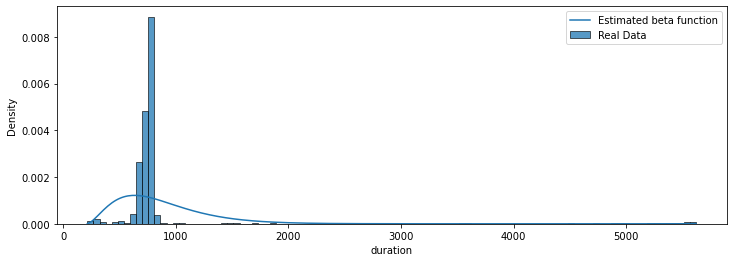

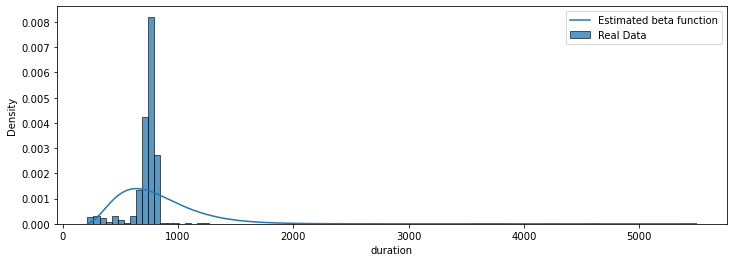

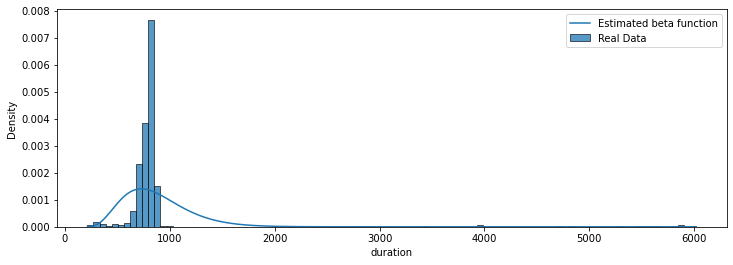

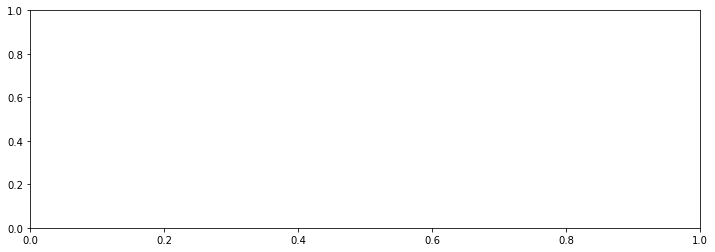

In [81]:
#0 = "/merged/jp_consensus_process_proposal.csv"
#1 = "/merged/jp_consensus_process_new_round.csv"
#2 = "/merged/jp_consensus_ensure_round_and_sync_up.csv"
#3 = "/merged/jp_consensus_process_proposal_without_sync.csv"


#Should work for 2,3 and 4
#Works for 2 and 4
frame_nr = 2
def plot_graphs(x):
    fig, ax = plt.subplots(figsize=(12,4))

    #data = data_frames[frame_nr + (x*len(tmp_frames))]['duration']
    data = data_frames[x*4 + frame_number]['duration']
    
    #data = data[round(0.2*len(data)):]

    #Clean the data a bit
    #data = data[data.between(data.quantile(.02), data.quantile(.99))]
    #data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]

    sns.histplot(data, ax=ax, stat="density", label="Real Data", bins=100)

    a, loc, scale = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    alpha, beta, loc, scale = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc, scale)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(min(data), max(data), 300)
    #ax.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
    ax.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    ax.legend();

    print("Gamma p score: " + str(p_gamma_fit))
    print("Beta p score: " + str(p_beta_fit))
    print("Percentage of data cleaned: " + str((len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) - len(data)) / len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) * 100))
    
for x in range(0, 16):
    plot_graphs(x)